# Part I: Simulate view of scene with perspective projection

- Using right-handed coordinates in this example
- E matrix is now E = TR (translation and rotation)
- Added quantisation (round image points to 3 d.p.)
- Added extra noise points

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('helpers.py','wb').write(src)

In [1]:
import helpers
import numpy as np
from helpers import projectPoints, transformCamera
from math import sin, cos, pi

In [2]:
# Define n random points in 1x1x1 cube centred at (0,0,2): 

n_corr = 20

# p = np.random.rand(n,3)*2 - 1.0 + np.array([[0,0,2.0]])

p = np.array([[ 0.47729982,  0.46821197,  2.82519478],
              [ 0.42268141, -0.24521877,  1.35673245],
              [-0.01436486,  0.47451121,  2.54364829],
              [ 0.22221251, -0.67802847,  2.48401469],
              [ 0.53139288,  0.98989222,  1.90058383],
              [ 0.26739713, -0.57282862,  2.08571485],
              [-0.00420308, -0.8873651 ,  2.30317347],
              [ 0.95345022, -0.45281222,  1.64367242],
              [-0.43965872, -0.42929066,  2.8768967 ],
              [-0.03042594, -0.44432101,  2.00269752],
              [-0.27269807, -0.61922827,  2.9905221 ],
              [ 0.33509766, -0.42812641,  2.17759225],
              [-0.6597356 , -0.65676217,  1.78080565],
              [ 0.79502118,  0.42769441,  2.68382864],
              [-0.70730296,  0.2737345 ,  2.23520083],
              [ 0.44392226,  0.32736849,  1.82209446],
              [-0.71203014,  0.04881414,  2.67555491],
              [ 0.54053719, -0.77533631,  1.12262847],
              [-0.03883526,  0.44478417,  2.47103904],
              [ 0.94593446,  0.01870913,  2.37024429]])

In [3]:
# Define camera parameters

f  = 1          # focal length
bu = bv = 1     # scaling factors
u0 = v0 = 0     # offsets

# Define camera position (0, 0, 0) 
cam_pos = np.array([0.0, 0.0, 0.0])

# Define camera orientation in world coordinates (aligned to world, rows are i, j, k vectors)
cam_or = np.eye(3)

In [4]:
u, v = projectPoints(p, cam_pos, cam_or, f, bu, bv, u0, v0)

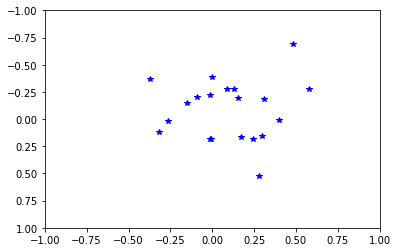

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot(u, v, 'b*')
plt.axis([-bu, bu, -bv, bv])
plt.gca().invert_yaxis()
plt.show()

## Interactive display of view from different camera positions and orientations 

In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(transformCamera, p=fixed(p), display=fixed(True),
         x     = (-2.0, +2.0, 0.01), 
         y     = (-2.0, +2.0, 0.01), 
         z     = (-2.0, +2.0, 0.01),
         roll  = ( -pi,  +pi, 0.01),   
         pitch = ( -pi,  +pi, 0.01),   
         yaw   = ( -pi,  +pi, 0.01),
         f=fixed(1), bu=fixed(1), bv=fixed(1), u0=fixed(0), v0=fixed(0)
        ) 

A Jupyter Widget

<function helpers.transformCamera>

-------------------------
# Part II: Particle Filter with TR as E matrix (assume K = I)

1. Set up two camera positions (translation and rotation)
2. Sample possible translation and rotation in 3 dimensions each, using particle filtering

## Set up two camera positions 

In [8]:
from helpers import cartesianToSpherical

diff = np.array([2.0, -0.7, 1.0, 0.5, -0.4, -1.0])
z1   = 0.3
pts1 = transformCamera(p, display=False, x=0, y=0, z=z1, roll=0, pitch=0, yaw=0)
pts2 = transformCamera(p, display=False, x=diff[0], y=diff[1], z=z1+diff[2], roll=diff[3], pitch=diff[4], yaw=diff[5])

# Add noise points
num_noise = 5
pts1 = np.concatenate((pts1, np.random.rand(num_noise, 2)*2 - 1.0), axis = 0)
pts2 = np.concatenate((pts2, np.random.rand(num_noise, 2)*2 - 1.0), axis = 0)

# Quantise image points to 3 d.p.
pts1 = np.around(pts1,3)
pts2 = np.around(pts2,3)

# In spherical coordinates
r, theta, phi = cartesianToSpherical(diff[0], diff[1], diff[2])
diff_sph = np.array([theta, phi, diff[3], diff[4], diff[5]])

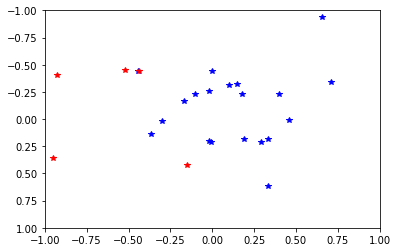

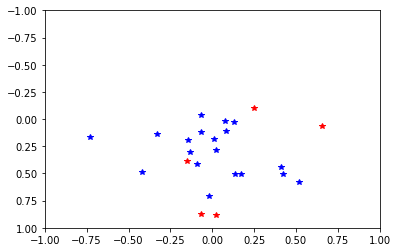

([-1, 1, -1, 1], None, None)

In [9]:
# Display pts1 and pts2
plt.plot(pts1[:n_corr, 0], pts1[:n_corr, 1], 'b*'), plt.plot(pts1[n_corr:, 0], pts1[n_corr:, 1], 'r*')
plt.axis([-bu, bu, -bv, bv]), plt.gca().invert_yaxis(), plt.show()
plt.plot(pts2[:n_corr, 0], pts2[:n_corr, 1], 'b*'), plt.plot(pts2[n_corr:, 0], pts2[n_corr:, 1], 'r*')
plt.axis([-bu, bu, -bv, bv]), plt.gca().invert_yaxis(), plt.show()

### List pts1 and pts2:

In [10]:
pts1

array([[ 0.189,  0.185],
       [ 0.4  , -0.232],
       [-0.006,  0.211],
       [ 0.102, -0.31 ],
       [ 0.332,  0.618],
       [ 0.15 , -0.321],
       [-0.002, -0.443],
       [ 0.71 , -0.337],
       [-0.171, -0.167],
       [-0.018, -0.261],
       [-0.101, -0.23 ],
       [ 0.178, -0.228],
       [-0.446, -0.444],
       [ 0.334,  0.179],
       [-0.365,  0.141],
       [ 0.292,  0.215],
       [-0.3  ,  0.021],
       [ 0.657, -0.943],
       [-0.018,  0.205],
       [ 0.457,  0.009],
       [-0.928, -0.406],
       [-0.44 , -0.439],
       [-0.149,  0.418],
       [-0.52 , -0.449],
       [-0.954,  0.358]])

In [11]:
pts2

array([[ 0.423,  0.509],
       [-0.421,  0.485],
       [ 0.17 ,  0.507],
       [ 0.075,  0.022],
       [ 0.162,  1.138],
       [-0.067,  0.119],
       [-0.069, -0.037],
       [-0.134,  0.306],
       [ 0.083,  0.106],
       [-0.145,  0.196],
       [ 0.13 ,  0.026],
       [ 0.01 ,  0.179],
       [-0.332,  0.138],
       [ 0.521,  0.578],
       [-0.088,  0.417],
       [-0.021,  0.711],
       [ 0.022,  0.282],
       [-0.73 ,  0.161],
       [ 0.136,  0.506],
       [ 0.412,  0.443],
       [ 0.658,  0.064],
       [-0.066,  0.87 ],
       [ 0.024,  0.883],
       [-0.149,  0.385],
       [ 0.249, -0.102]])

## 2. Run Particle Filter

2018-07-17: Start particle filter with ground truth 
- Check that ground truth has perfect score
- Experiment with small m (few samples) and small sigma
- Try increasing sigma and epsilon

2018-07-24: Start with uniform cube of samples around the solution
- Added quantisation and noise points (epsilon cannot go below 0.0005)
- Add further constraint - enforce one-to-one epiline-point matching

C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


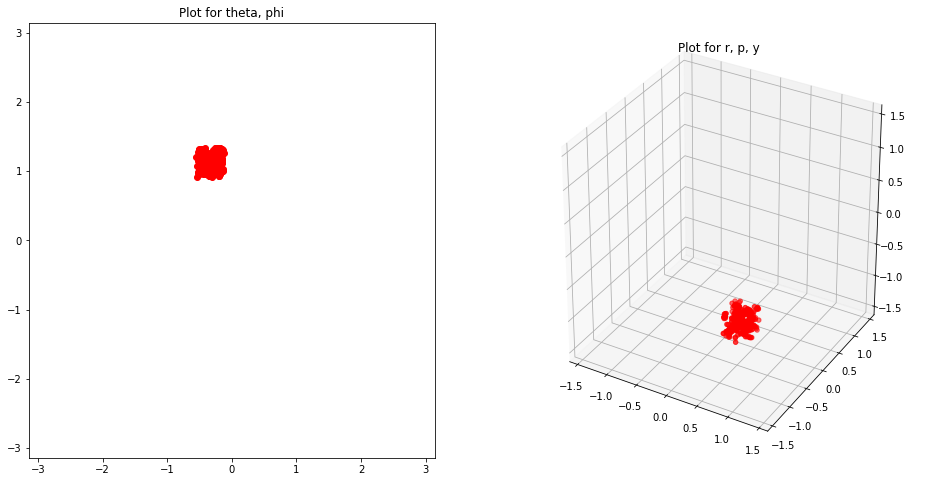

First 200 scores: [11, 10, 7, 10, 5, 10, 6, 11, 8, 9, 9, 7, 8, 8, 9, 7, 8, 13, 9, 8, 6, 11, 10, 11, 9, 6, 4, 11, 9, 4, 8, 6, 12, 8, 10, 10, 9, 11, 5, 7, 9, 13, 11, 6, 15, 9, 6, 10, 4, 10, 10, 11, 9, 9, 11, 10, 7, 10, 9, 8, 8, 4, 9, 10, 12, 9, 9, 11, 7, 11, 9, 8, 11, 8, 9, 7, 15, 7, 9, 11, 9, 6, 10, 9, 10, 7, 10, 12, 7, 8, 12, 14, 8, 10, 14, 12, 8, 7, 7, 8, 9, 7, 10, 9, 10, 7, 12, 8, 8, 11, 7, 7, 13, 10, 11, 9, 10, 7, 9, 14, 9, 8, 14, 8, 11, 9, 11, 6, 9, 13, 13, 8, 7, 8, 9, 11, 7, 12, 11, 9, 9, 11, 8, 11, 11, 10, 12, 12, 10, 9, 12, 8, 9, 8, 9, 9, 8, 9, 7, 6, 7, 8, 13, 9, 9, 7, 11, 8, 12, 6, 12, 8, 10, 13, 9, 8, 8, 13, 11, 7, 8, 15, 8, 9, 7, 7, 9, 10, 11, 13, 7, 8, 13, 9, 11, 14, 13, 6, 6, 9]
Non-match ratio: 0.939284 (2599/2767)
Sigma: ['0.010000', '0.010000', '0.010000', '0.010000', '0.010000']
Epsilon: 0.000500
Iteration: 1


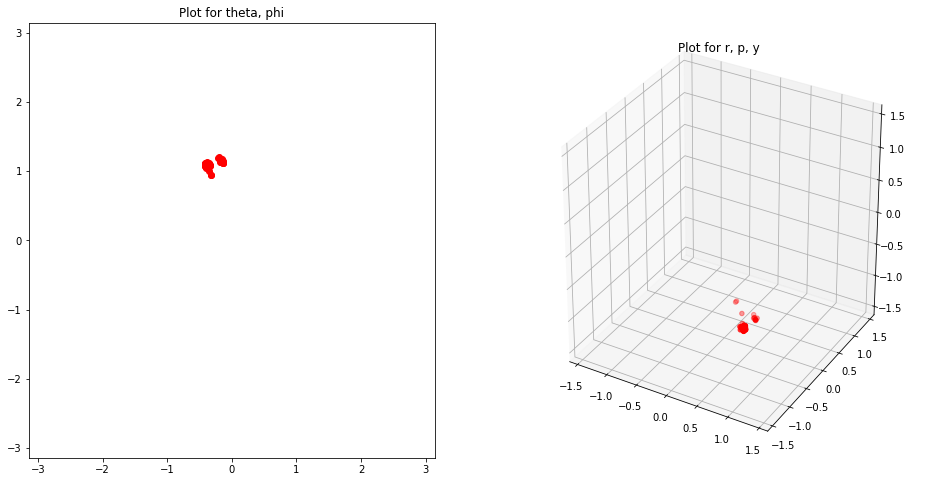

First 200 scores: [15, 18, 15, 15, 16, 15, 15, 16, 16, 19, 17, 11, 15, 19, 12, 14, 16, 14, 16, 15, 15, 17, 15, 20, 17, 14, 15, 16, 16, 15, 17, 15, 14, 17, 13, 17, 17, 14, 19, 18, 17, 16, 18, 19, 16, 17, 19, 15, 16, 17, 17, 15, 17, 16, 18, 14, 11, 14, 17, 15, 16, 18, 15, 15, 17, 15, 17, 18, 15, 19, 18, 14, 14, 18, 14, 18, 16, 13, 14, 16, 17, 15, 14, 13, 17, 17, 18, 17, 17, 13, 16, 16, 15, 15, 17, 16, 14, 15, 14, 15, 20, 15, 17, 18, 14, 16, 16, 15, 14, 14, 16, 13, 19, 17, 15, 18, 18, 16, 16, 15, 13, 15, 14, 15, 15, 16, 18, 16, 11, 16, 15, 16, 16, 17, 15, 15, 18, 16, 17, 14, 14, 13, 13, 16, 15, 19, 15, 18, 15, 15, 16, 16, 17, 15, 16, 17, 13, 18, 16, 16, 15, 17, 14, 12, 15, 14, 17, 17, 10, 16, 14, 19, 13, 16, 15, 15, 17, 16, 17, 16, 15, 17, 14, 18, 18, 17, 15, 19, 19, 15, 15, 16, 16, 18, 16, 14, 17, 17, 16, 17]
Non-match ratio: 0.618787 (2938/4748)
Sigma: ['0.006000', '0.006000', '0.006000', '0.006000', '0.006000']
Epsilon: 0.000500
Iteration: 6


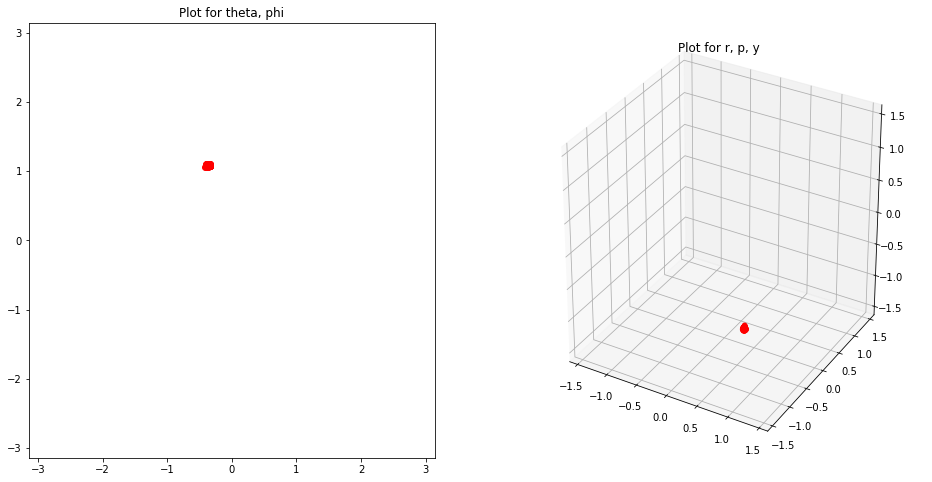

First 200 scores: [15, 15, 15, 16, 17, 19, 15, 17, 16, 16, 16, 19, 15, 15, 20, 17, 17, 16, 18, 15, 17, 19, 13, 10, 15, 15, 19, 17, 17, 17, 19, 17, 13, 17, 17, 17, 13, 15, 17, 14, 15, 16, 14, 16, 15, 16, 15, 18, 18, 19, 15, 17, 14, 19, 16, 16, 14, 15, 18, 19, 15, 16, 16, 13, 19, 16, 19, 18, 14, 14, 15, 15, 17, 15, 16, 17, 15, 18, 16, 15, 17, 17, 15, 15, 18, 17, 19, 14, 15, 15, 14, 16, 15, 17, 19, 18, 16, 18, 16, 15, 16, 17, 15, 19, 16, 16, 16, 16, 15, 19, 19, 20, 19, 17, 15, 17, 19, 14, 18, 15, 18, 17, 19, 17, 20, 16, 19, 16, 16, 14, 17, 16, 18, 17, 15, 19, 17, 14, 15, 17, 12, 16, 20, 15, 16, 18, 16, 15, 17, 19, 15, 16, 18, 15, 14, 19, 15, 18, 16, 18, 13, 16, 16, 17, 19, 17, 14, 14, 14, 15, 19, 17, 15, 18, 17, 18, 17, 16, 17, 19, 19, 15, 14, 16, 16, 17, 12, 15, 14, 19, 19, 15, 15, 16, 14, 19, 16, 13, 19, 17]
Non-match ratio: 0.529894 (2588/4884)
Sigma: ['0.006000', '0.006000', '0.006000', '0.006000', '0.006000']
Epsilon: 0.000500
Iteration: 10


In [20]:
from helpers import ParticleFilter, generateSamples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 10
m = 300

# Set range to be a uniform cube of length 1 around the solution
ranges = np.array([[*diff_sph-0.2, 1/m], [*diff_sph+0.2, 1/m]]).T  

# ranges = np.array([[-2.0, 2.0], 
#                    [-2.0, 2.0], 
#                    [-2.0, 2.0], 
#                    [-pi/2, pi/2], 
#                    [-pi/2, pi/2], 
#                    [-pi/2, pi/2], 
#                    [1/m, 1/m]])  

e = 0.0005
sigma = np.array([*[0.01]*2, *[0.01]*3]) # np.array([0.01] * 6) # np.array([0.1, 0.1, 0.1, 0.3, 0.3, 0.3])

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.6
sigma_interval = 5 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 1 #0.5
e_interval = 5

# ---------------------------------------------------------

S_new = generateSamples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, n_corr, epsilon = e, epipole_t = 0.3, norm_mode = "softmax")
    
    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (16,8))

        ax1 = fig.add_subplot(121)
        ax1.scatter(*S_new[:2,:], c= 'red')
        ax1.set_xlim(-pi, pi)
        ax1.set_ylim(-pi, pi)
        ax1.set_title("Plot for theta, phi")

        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(*S_new[2:,:], c= 'red')
        ax2.set_xlim3d(-pi/2, pi/2)
        ax2.set_ylim3d(-pi/2, pi/2)
        ax2.set_zlim3d(-pi/2, pi/2)
        ax2.set_title("Plot for r, p, y")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
    
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor

## 3. Recover solution from Particle Filter
- Visually inspect number of clusters and find their centroids

In [21]:
# Print average
ave = np.average(S_new[:-1, :], axis = 1)
print("Average:      " + str(ave))
print("Ground truth: " + str(diff_sph))

Average:      [-0.36241865  1.08690192  0.658904   -0.5701194  -0.97037606]
Ground truth: [-0.33667482  1.12985649  0.5        -0.4        -1.        ]


[[-0.36241865  1.08690192  0.658904   -0.5701194  -0.97037606]]


C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


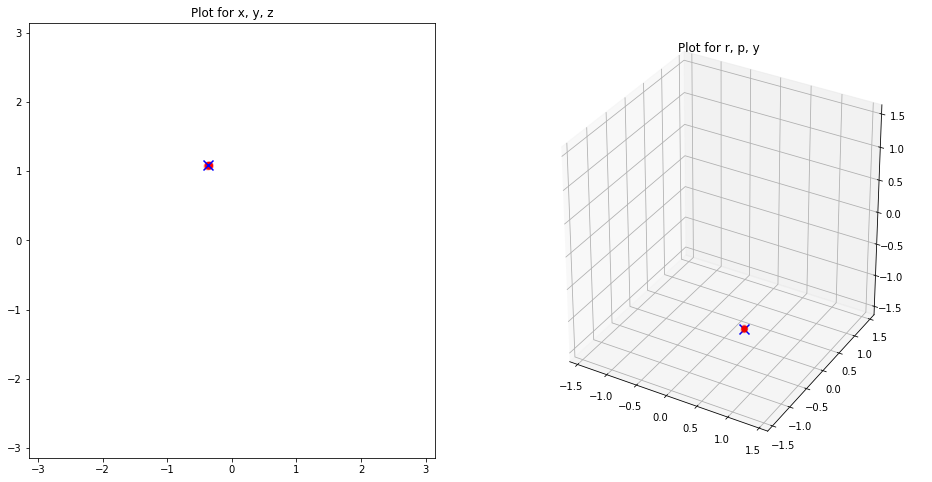

In [22]:
# Retrieve clusters
from sklearn.cluster import KMeans

num_clusters = 1

kmeans_model = KMeans(n_clusters = num_clusters).fit(S_new[:-1, :].T)
results = kmeans_model.cluster_centers_
print(results)

res = results.T

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121)
ax1.scatter(*S_new[:2,:m//4], c='red', alpha=0.05)
ax1.scatter(*res[:2,:], c='blue', marker='x', s=100)
ax1.set_xlim(-pi, pi)
ax1.set_ylim(-pi, pi)
ax1.set_title("Plot for x, y, z")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*S_new[2:,:m//4], c='red', alpha=0.05)
ax2.scatter(*res[2:,:], zdir='z', c='blue', marker='x', s=100)
ax2.set_xlim3d(-pi/2, pi/2)
ax2.set_ylim3d(-pi/2, pi/2)
ax2.set_zlim3d(-pi/2, pi/2)
ax2.set_title("Plot for r, p, y")
plt.show()

## 4. Check solution

In [23]:
# Compare translation with ground truth by normalising both vectors
gt = np.array([*diff_sph[:2]])
for res_idx in range(results.shape[0]):
    t  = results[res_idx, :2]
    
    print("Solution t:   " + str(t))
    print("Ground truth: " + str(gt/np.linalg.norm(gt)))
    print("Difference:   " + str(t - gt/np.linalg.norm(gt)))
    print()

Solution t:   [-0.36241865  1.08690192]
Ground truth: [-0.2855715   0.95835741]
Difference:   [-0.07684716  0.12854451]



In [25]:
# Compare rotation with ground truth by taking modulo wrt. 2pi
gt = np.array([*diff_sph[2:]]) % (2*pi)
for res_idx in range(results.shape[0]):
    r = results[res_idx, 2:] % (2*pi)
    print("Solution r:   " + str(r))
    print("Ground truth: " + str(gt))

    diff_r = np.minimum((r - gt) % (2*pi), (gt - r) % (2*pi))
    print("Difference:   " + str(diff_r))
    print()

Solution r:   [0.658904   5.7130659  5.31280925]
Ground truth: [0.5        5.88318531 5.28318531]
Difference:   [0.158904   0.1701194  0.02962394]



In [26]:
# Construct E from solution t and r, check that (pts1)' E (pts2) = 0

from helpers import rpy2R, xyz2T, sphericalToCartesian

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

E_products = []
for res_idx in range(results.shape[0]):
    t  = sphericalToCartesian(1, *results[res_idx, :2])
    r  = results[res_idx, 2:]
    
    T = xyz2T(t[0], t[1], t[2])
    R = rpy2R(r[0], r[1], r[2])
    
    E_product = []
    for i in range(pts1_uvf.shape[0]):
        E_product.append(pts1_uvf[i, :] @ T @ R @ pts2_uvf[i, :].T)
    E_products.append(E_product)

for res in E_products:
    print("Result number: " + str(res_idx))
    for pt in res:
        print(pt)
    print()

Result number: 0
0.010973421909288572
-0.037977231400076694
0.00019885504741490312
0.012581125859426404
-0.0011234362703358425
-0.0006771926685702548
0.013171971328485438
-0.0196668805982623
0.01277656663898355
-0.009153207636516739
0.0188407319781327
-0.0020875838820226256
-0.015005566702722406
0.007901350038638955
-0.013724047170787956
-0.02355591881365615
-0.00035325449504794437
0.0007047741455543655
-0.002520590939787015
-0.0026574057361730685
0.9163284991331789
0.7836399274681936
0.16929334707850474
0.35276985204838085
-0.3692240109259123



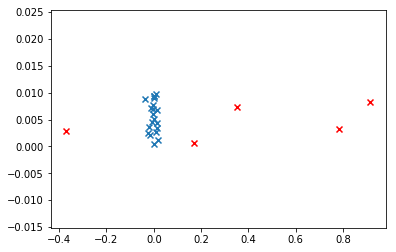

In [27]:
# Visualise (pts1)' E (pts2)

for i in E_products:
    plt.scatter(i[:n_corr], np.random.rand(len(i[:n_corr]))*0.01, marker='x') # perturb vertically to see 
    plt.scatter(i[n_corr:], np.random.rand(len(i[n_corr:]))*0.01, marker='x', color='r') 

## 5. Check ground truth solution with (pts1)' E (pts2) = 0 for comparison

In [28]:
from helpers import rpy2R, xyz2T

t = np.array(diff)

T = xyz2T(t[0], t[1], t[2])
R = rpy2R(t[3], t[4], t[5])
E = np.dot(T, R)

for i in range(pts1_uvf.shape[0]):
    print(pts1_uvf[i, :] @ E @ pts2_uvf[i, :].T)

0.0003105932605822481
0.00047735237606427727
-0.0001736938324603532
0.00013277641977925414
0.001147376814040646
0.001231534949535984
0.0002584851920494069
-0.0002852449462026896
0.001669873898089369
0.0006342895693782213
-0.0002692657966880396
0.0005203009623593879
0.0020286596103288312
-0.0002841926524099758
0.0005952755934243159
5.7519863616350975e-05
-0.0013931206852167977
0.0008864591764269347
-0.0009350976941113753
0.0002680957755564206
1.943556573625365
1.9727244073062817
0.4297421565979729
0.881583743455155
-0.9991999893149899
